In [29]:
import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import DataLoader # loads data in batches
from torchvision import datasets # load MNIST
import torchvision.transforms as T # transformers for computer vision

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar

In [32]:
mytransform = T.ToTensor() # image (3D array) to Tensor

train_data = datasets.MNIST(root = './', download=True, train = True, transform = mytransform)
test_data = datasets.MNIST(root = './', download=True, train = False, transform = mytransform)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.93MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.74MB/s]


In [33]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size = 100, shuffle=True)
# the test loader can be bigger and doesn't need to be shuffled
test_loader =  DataLoader(test_data,  batch_size = 500, shuffle=False)

In [34]:
from dataclasses import dataclass

@dataclass
class Loader:
    """
    Custom class to accomodate train and test loader iterators
    """
    train: DataLoader  # train DataLoader iterable object
    test:  DataLoader  # test DataLoader iterable object

myloader = Loader(train = train_loader, test = test_loader)
print(myloader)

Loader(train=<torch.utils.data.dataloader.DataLoader object at 0x7dbed7db4f20>, test=<torch.utils.data.dataloader.DataLoader object at 0x7dbed7db5d00>)


In [35]:
class MultilayerPerceptron(nn.Module):
    """
    A simple multilayer perceptron network

    """
    def __init__(self, in_features = 784, out_features=10):
        """
        * 784 input layers
        * 2 hiden layers of 120 and 84 neurons respectively
        * 10 output layer
        """
        super(MultilayerPerceptron, self).__init__()

        self.fc1 = nn.Linear(in_features, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_features)

    def forward(self, X):

        X = F.relu(self.fc1(X)) # Rectified Linear Unit (ReLU)
        X = F.relu(self.fc2(X)) # Rectified Linear Unit (ReLU)
        X = self.fc3(X)

        return F.log_softmax(X, dim = 1) # multi-class classification, the sum of all probabilities is 1

In [36]:
torch.manual_seed(101)

mymodel = MultilayerPerceptron() # default params are in_features = 784, out_features=10
mymodel # check topology

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [37]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(mymodel.parameters(), lr = 1e-3)

In [38]:
params = [p.numel() for p in mymodel.parameters() if p.requires_grad]
np.sum(params)

np.int64(105214)

In [39]:
# Plot 10 images
myiter = iter(myloader.train)
img, label = myiter.__next__() # only one iteration
img.shape # batch_size, channel, Height, Width

torch.Size([100, 1, 28, 28])

In [40]:
y_pred = mymodel( img.view(100,-1) )
y_pred.shape # 100 x 10, meaning for every batch (100) we obtain  (10 probabilities) predictions

torch.Size([100, 10])

In [41]:
val, idx = torch.max(y_pred, dim=1) # dim 1 is for the output
idx # indices == predictions

tensor([2, 2, 2, 2, 8, 2, 2, 8, 2, 6, 8, 8, 8, 8, 8, 8, 8, 2, 6, 2, 8, 2, 2, 2,
        8, 2, 6, 8, 6, 2, 6, 8, 2, 2, 8, 7, 6, 6, 2, 2, 2, 8, 2, 2, 6, 6, 8, 8,
        8, 2, 2, 7, 8, 6, 2, 8, 2, 2, 2, 6, 2, 2, 2, 6, 7, 2, 8, 8, 6, 6, 2, 8,
        2, 6, 7, 8, 6, 8, 6, 2, 2, 2, 2, 2, 2, 6, 8, 8, 2, 8, 6, 2, 2, 6, 2, 2,
        8, 8, 2, 2])

In [42]:
# tracking variables

class Loss:
    """ Class to monitor train and test lost"""
    train: list = []
    test: list = []


class Accuracy:
    """ Class to monitor train and test accuracy"""
    train: list = []
    test: list = []

In [43]:
%%time

epochs = 10
for epoch in tqdm(range(epochs)):
    # we set the number of True positives to zero in every epoch
    train_corr = 0
    test_corr = 0

    # training: we run the train dataset in batches of 100 images, meaning that run the loader 600 times (600 x 100 = 60,000 images)
    for batch, (img, label) in enumerate(myloader.train):
        batch +=1
        y_pred = mymodel( img.view(100,-1) ) # batch size for train is 100
        loss = criterion(y_pred, label)

        # last 10-layer neurons into one result
        _, prediction = torch.max(y_pred,dim = 1)
        train_corr += (prediction == label).sum() # sum of correct predictions


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # monitor loss and accuracy every 200 train batches of 100 images ( 3 times per epoch)
        if batch%200 == 0:
            acc = 100 * (train_corr.item() / (batch*100) ) # correct predictions divided by images in batches
            print( f'Epoch:{epoch:2d} batch: {batch:2d} loss: {loss.item():4.4f} Accuracy: {acc:4.4f} %' )

    Loss.train.append( loss.item() ) # store loss at the end of epoch
    accuracy = 100 * (train_corr.item() / (batch*100) ) # accuracy is 100 x train_corr.item()/60_000
    Accuracy.train.append( accuracy ) # store accuracy at the end of epoch


    # validation (test). Here we run batches of 500 images, the test loader runs 120 times (120 x 500 = 60,000)
    with torch.no_grad():
        for batch, (img, label) in enumerate(myloader.test):
            batch +=1
            y_val = mymodel( img.view(500,-1) ) # batch size for test is 500
            _, predicted = torch.max( y_val, dim = 1)
            test_corr += (predicted == label).sum()

    loss = criterion( y_val,label )
    Loss.test.append( loss.item() )
    accuracy = 100 * (test_corr.item()/ (batch*500) ) # accuracy is 100 x train_corr.item()/60,000
    Accuracy.test.append( accuracy )


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 batch: 200 loss: 0.2996 Accuracy: 82.6550 %
Epoch: 0 batch: 400 loss: 0.2726 Accuracy: 87.2475 %
Epoch: 0 batch: 600 loss: 0.1815 Accuracy: 89.3183 %


 10%|█         | 1/10 [00:11<01:40, 11.13s/it]

Epoch: 1 batch: 200 loss: 0.1704 Accuracy: 94.6100 %
Epoch: 1 batch: 400 loss: 0.0507 Accuracy: 95.0100 %
Epoch: 1 batch: 600 loss: 0.1428 Accuracy: 95.2500 %


 20%|██        | 2/10 [00:22<01:28, 11.08s/it]

Epoch: 2 batch: 200 loss: 0.1678 Accuracy: 96.5200 %
Epoch: 2 batch: 400 loss: 0.1715 Accuracy: 96.5000 %
Epoch: 2 batch: 600 loss: 0.1084 Accuracy: 96.5800 %


 30%|███       | 3/10 [00:33<01:18, 11.15s/it]

Epoch: 3 batch: 200 loss: 0.1408 Accuracy: 97.4350 %
Epoch: 3 batch: 400 loss: 0.0127 Accuracy: 97.4800 %
Epoch: 3 batch: 600 loss: 0.0746 Accuracy: 97.4133 %


 40%|████      | 4/10 [00:44<01:07, 11.24s/it]

Epoch: 4 batch: 200 loss: 0.0551 Accuracy: 98.0250 %
Epoch: 4 batch: 400 loss: 0.1177 Accuracy: 97.9375 %
Epoch: 4 batch: 600 loss: 0.1012 Accuracy: 97.9800 %


 50%|█████     | 5/10 [00:56<00:56, 11.25s/it]

Epoch: 5 batch: 200 loss: 0.0772 Accuracy: 98.5200 %
Epoch: 5 batch: 400 loss: 0.0259 Accuracy: 98.4225 %
Epoch: 5 batch: 600 loss: 0.0323 Accuracy: 98.3583 %


 60%|██████    | 6/10 [01:07<00:45, 11.44s/it]

Epoch: 6 batch: 200 loss: 0.0233 Accuracy: 98.8550 %
Epoch: 6 batch: 400 loss: 0.0402 Accuracy: 98.6800 %
Epoch: 6 batch: 600 loss: 0.0302 Accuracy: 98.6633 %


 70%|███████   | 7/10 [01:19<00:34, 11.41s/it]

Epoch: 7 batch: 200 loss: 0.0042 Accuracy: 99.0150 %
Epoch: 7 batch: 400 loss: 0.0070 Accuracy: 98.9075 %
Epoch: 7 batch: 600 loss: 0.0336 Accuracy: 98.8567 %


 80%|████████  | 8/10 [01:29<00:22, 11.20s/it]

Epoch: 8 batch: 200 loss: 0.0085 Accuracy: 99.1950 %
Epoch: 8 batch: 400 loss: 0.0787 Accuracy: 99.1750 %
Epoch: 8 batch: 600 loss: 0.0494 Accuracy: 99.1383 %


 90%|█████████ | 9/10 [01:40<00:11, 11.05s/it]

Epoch: 9 batch: 200 loss: 0.0469 Accuracy: 99.3500 %
Epoch: 9 batch: 400 loss: 0.0213 Accuracy: 99.3225 %
Epoch: 9 batch: 600 loss: 0.0210 Accuracy: 99.2500 %


100%|██████████| 10/10 [01:51<00:00, 11.18s/it]

CPU times: user 1min 50s, sys: 153 ms, total: 1min 50s
Wall time: 1min 51s


In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import sys

Kullanılan cihaz: cpu


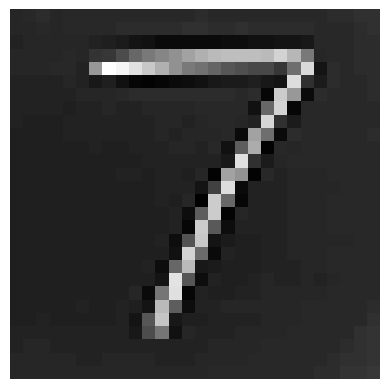

---
Tahmin Edilen Rakam: 1
Modelin Emin Olma Olasılığı: 46.77%
---


In [151]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image, ImageOps
import sys
import matplotlib.pyplot as plt

def preprocess_image(image_path, show_processed_image=False):
    try:
        img = Image.open(image_path).convert('L')
    except IOError:
        print(f"Hata: '{image_path}' yolu açılamadı.")
        return None, None

    img_inverted = ImageOps.invert(img)

    img_resized = img_inverted.resize((28, 28), Image.LANCZOS)


    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    tensor = preprocess(img_resized)
    tensor = tensor.unsqueeze(0)

    if show_processed_image:
        plt.imshow(img_resized, cmap='gray')
        plt.axis('off') # Eksenleri gizle
        plt.show()

    return tensor

IMAGE_PATH = "digit_5.jpg"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

mymodel.eval()

# 2. Görüntüyü işle
image_tensor = preprocess_image(IMAGE_PATH, show_processed_image=True)

if image_tensor is not None:
    image_tensor = image_tensor.to(device)

    # 3. Tahmin
    with torch.no_grad():
        output = mymodel(image_tensor.view(image_tensor.shape[0], -1))
        prediction = torch.argmax(output, dim=1)

        probabilities = F.softmax(output, dim=1)
        top_prob, top_class = probabilities.topk(1, dim=1)

        print("---")
        print(f"Tahmin Edilen Rakam: {prediction.item()}")
        print(f"Modelin Emin Olma Olasılığı: {top_prob.item()*100:.2f}%")
        print("---")